In [1]:
# Standard library imports
import itertools
import time

# Third-party imports for data manipulation and calculation
import numpy as np
import pandas as pd

# Machine Learning and data processing libraries
from sklearn.datasets import make_moons
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Deep Learning libraries
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.text import Tokenizer

# Visualization library
import matplotlib.pyplot as plt

# Third-party utilities
from tqdm import tqdm

# Readme

The code is in the first part at the end of the file you can find the report and some specific code for the report but the most important code is in the front

# Mining Massive Data (SS2024)
## Programming Assignment 2 (Large-scale SVM Training)



## Dataloading

In this part we have the functions

to load the regular dataset

to load the imdb dataset 

to load the imdb dataset and drop 50% of the features as whished in the report later

In [2]:
# helper functions
def load_dataset(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # print last 10 values of y
    #print("Last 10 values of y: ", y[-10:])
    
    # print the shape of X and y
    print("X shape: ", X.shape)
    print("y shape: ", y.shape)
    return X, y

def load_imdb_dataset_with_dropout(num_samples=100, max_length=500, dropout_prob=0.5):
    # Load the dataset
    (x_train, y_train), (x_test, y_test) = imdb.load_data(
        path="imdb.npz", num_words=None, skip_top=0, maxlen=None,
        seed=113, start_char=1, oov_char=2, index_from=3
    )

    # Cut the dataset to the specified number of samples
    x_train = x_train[:num_samples]
    y_train = y_train[:num_samples]

    # Pad the sequences to have uniform length
    x_train = pad_sequences(x_train, maxlen=max_length)
    y_train = np.array(y_train)

    # Print the shape of the dataset
    print("Shape of x_train:", x_train.shape)

    # Apply feature dropout
    # Generate a random mask of the same shape as x_train
    mask = np.random.rand(*x_train.shape) < (1 - dropout_prob)
    # Apply the mask to x_train to drop some features
    x_train = x_train * mask
    return x_train, y_train
    
    
def load_imdb_dataset(num_samples=100, max_length=500):
    # Load the dataset
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz", num_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3)
    x_train = x_train[:num_samples]
    y_train = y_train[:num_samples]
    # create np array of both 
    x_train = pad_sequences(x_train, maxlen=max_length)
    print("Shape of x_train: ", x_train.shape)
    y_train = np.array(y_train)
    return x_train, y_train

### Toydata

first take a look how the toydata_tiny looks like between feature 1 and 2 and as we can see the svm should get a pretty good result here as the data is good seperable

X shape:  (200, 2)
y shape:  (200,)


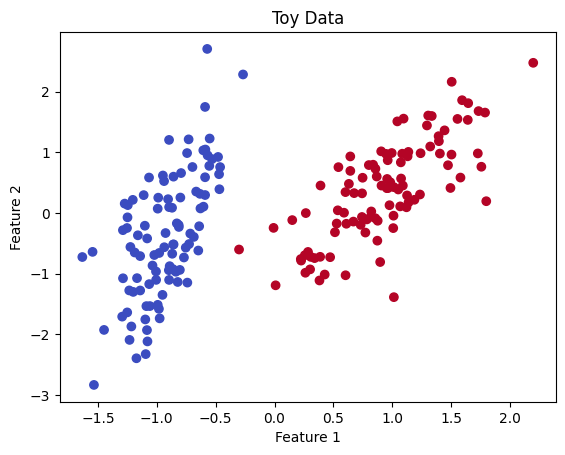

In [3]:
#plot X and y values
X_tiny, y_tiny = load_dataset("toydata_tiny.csv")
plt.scatter(X_tiny[:, 0], X_tiny[:, 1], c=y_tiny, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Toy Data')
plt.show()

here is also a plot for the toydata large which has more features but the data still looks pretty clean 

X shape:  (200000, 8)
y shape:  (200000,)


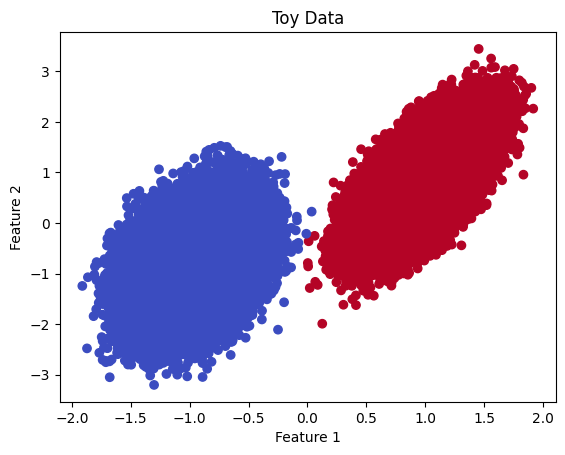

In [4]:
X_large, y_large = load_dataset("toydata_large.csv")
plt.scatter(X_large[:, 2], X_large[:, 3], c=y_large, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Toy Data')
plt.show()

### Imdbdata

Here the imdb data is loaded and plottet between two features andd as we can see this looks pretty bad for a svm to get much accuracy here, so the excepctations should be much lower in comparison to the toydata here

Shape of x_train:  (1000, 2)


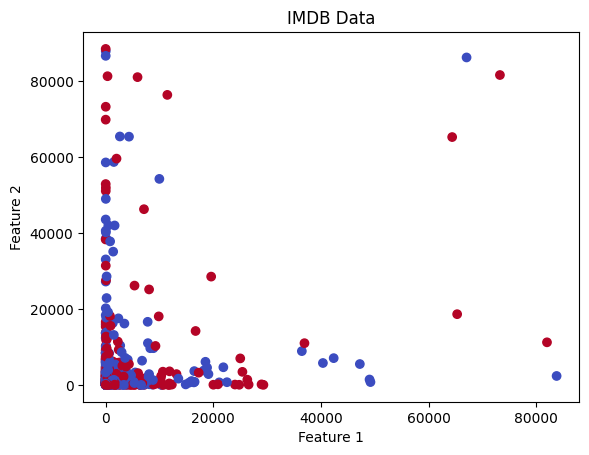

In [5]:
# Usage
X_imdb, y_imdb = load_imdb_dataset(1000,2)

# plot the features of X to y value (0/1)
plt.scatter(X_imdb[:, 0], X_imdb[:, 1], c=y_imdb, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('IMDB Data')
plt.show()

### Preprocessing(optional)

this is some preprocessing we tested in order to improve the accurcay of the imdb datasets it uses a lot of libaries and some different techniques, however it really increased the performance of the svm for the imdb dataset and madde it much better

you can try it out by using load_and_preprocess_imdb in the best parameter search for example 

In [6]:
'''

from sklearn.feature_selection import SelectKBest, chi2

def select_features(X, y, k=500):
    # Apply Chi-squared test to select the top k features
    chi2_selector = SelectKBest(chi2, k=k)
    X_kbest_features = chi2_selector.fit_transform(X, y)
    return X_kbest_features

def apply_lda(X, y):
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X, y)
    return X_lda


import matplotlib.pyplot as plt

def plot_data(X, y):
    plt.figure(figsize=(8, 4))
    plt.scatter(X[:, 0], np.zeros_like(X[:, 0]), c=y, cmap='coolwarm', alpha=0.5)
    plt.colorbar()  # Show color scale
    plt.xlabel('Projected Feature')
    plt.ylabel('Dummy Zero Axis')
    plt.title('IMDB Data Projection via LDA')
    plt.show()



def load_and_preprocess_imdb(num_samples=1000, max_length=500, num_features=10000, top_k_features=500):
    # Load the IMDB dataset
    (x_train, y_train), _ = imdb.load_data(num_words=num_features)
    x_train = x_train[:num_samples]
    y_train = y_train[:num_samples]

    # Pad the sequences to ensure they are of equal length
    x_train_padded = pad_sequences(x_train, maxlen=max_length)

    # Convert the integer sequences to strings (for TF-IDF)
    # Each token (integer) is converted directly to a string
    x_train_text = [" ".join(map(str, seq)) for seq in x_train_padded]

    # Initialize and apply a TF-IDF transformation
    tfidf = TfidfVectorizer(max_features=num_features, dtype=np.float32)
    x_train_tfidf = tfidf.fit_transform(x_train_text)

    # Convert the sparse TF-IDF matrix to a dense format
    x_train_tfidf_dense = x_train_tfidf.toarray()

    # Select the top k features based on the chi-squared statistic
    selector = SelectKBest(chi2, k=top_k_features)
    x_train_kbest = selector.fit_transform(x_train_tfidf_dense, y_train)

    # Apply Linear Discriminant Analysis (LDA) for dimensionality reduction
    lda = LinearDiscriminantAnalysis(n_components=1)
    x_train_lda = lda.fit_transform(x_train_kbest, y_train)
    
    return x_train_lda, y_train

# Load and preprocess the data
X_processed, y_processed = load_and_preprocess_imdb()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.25, random_state=42)

# Initialize and train the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM model on the test set: {accuracy:.2f}")

# Optional: Visualization of decision boundary
plt.scatter(X_processed[:, 0], np.zeros_like(X_processed[:, 0]), c=y_processed, cmap='coolwarm', alpha=0.5)
plt.scatter(X_test[:, 0], np.zeros_like(X_test[:, 0]), c=y_pred, marker='x')
plt.colorbar()  # Show color scale
plt.xlabel('Projected Feature by LDA')
plt.ylabel('Dummy Zero Axis')
plt.title('IMDB Data Projection and SVM Decision Boundary')
plt.show()'''

'\n\nfrom sklearn.feature_selection import SelectKBest, chi2\n\ndef select_features(X, y, k=500):\n    # Apply Chi-squared test to select the top k features\n    chi2_selector = SelectKBest(chi2, k=k)\n    X_kbest_features = chi2_selector.fit_transform(X, y)\n    return X_kbest_features\n\ndef apply_lda(X, y):\n    lda = LinearDiscriminantAnalysis(n_components=1)\n    X_lda = lda.fit_transform(X, y)\n    return X_lda\n\n\nimport matplotlib.pyplot as plt\n\ndef plot_data(X, y):\n    plt.figure(figsize=(8, 4))\n    plt.scatter(X[:, 0], np.zeros_like(X[:, 0]), c=y, cmap=\'coolwarm\', alpha=0.5)\n    plt.colorbar()  # Show color scale\n    plt.xlabel(\'Projected Feature\')\n    plt.ylabel(\'Dummy Zero Axis\')\n    plt.title(\'IMDB Data Projection via LDA\')\n    plt.show()\n\n\n\ndef load_and_preprocess_imdb(num_samples=1000, max_length=500, num_features=10000, top_k_features=500):\n    # Load the IMDB dataset\n    (x_train, y_train), _ = imdb.load_data(num_words=num_features)\n    x_train

## Evaluation methods
These methods are basic methods for the svms and are used from all implementations



In [7]:
def predict(X, w):
    """
    Predict using the trained weights of the SVM.
    - X: feature matrix
    - w: weight vector
    """
    return np.sign(np.dot(X, w))

def predict_rff(X, w, omega, b):
    """
    Predict with the SVM trained on RFF-transformed data.
    - X: original feature matrix
    - w: trained weight vector
    - omega: frequencies matrix used for RFF
    - b: biases used for RFF
    """
    X_transformed = rff_gaussian_transform(X, omega, b)
    return np.sign(np.dot(X_transformed, w))

def accuracy(y_true, y_pred):
    """
    Calculate the accuracy of predictions.
    - y_true: true labels
    - y_pred: predicted labels
    """
    return np.mean(y_true == y_pred)

## Parameter evaluation

These functions take a couple of models and the datasets to find the best ones

`evaluate_models_k` uses 5 cross validation and is used for toydata
`evaluate_models` is just regular evaluationm without 5 cross validation

This methods help to find the optimal parameters please look a bit down for further details

In [8]:
def evaluate_models_k(datasets, model_types, params):
    """
    Evaluates different model types on datasets with various parameter combinations using 5-fold cross-validation.

    Args:
        datasets: A dictionary with dataset names as keys and (X, y) tuples as values.
        model_types: A list of strings denoting the types of models to evaluate.
        params: A dictionary with model types as keys and lists of parameter combinations as values.
    """
    results = {}

    # Iterate over each dataset
    for name, (X, y) in datasets.items():
        results[name] = {}
        if name == 'imdb':
            y = np.where(y == 0, -1, 1)  # Convert labels

        for model_type in model_types:
            best_accuracy = 0
            best_params = {}

            param_combinations = params[model_type]
            progress_bar = tqdm(param_combinations, desc=f"Processing {name} - {model_type}")

            for param_comb in progress_bar:
                # Initialize KFold with 5 splits
                kf = KFold(n_splits=5)

                fold_accuracies = []

                for train_index, test_index in kf.split(X):
                    # Split the data into training and testing sets
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    # Train model
                    if model_type == 'linear':
                        w = train_svm_linear(X_train, y_train, **param_comb)
                        predictions = predict(X_test, w)
                    elif model_type == 'adagrad':
                        w = train_svm_adagrad(X_train, y_train, **param_comb)
                        predictions = predict(X_test, w)
                    elif model_type == 'rff':
                        w, omega, b = train_svm_rff(X_train, y_train, **param_comb)
                        predictions = predict_rff(X_test, w, omega, b)

                    acc = accuracy(y_test, predictions)
                    fold_accuracies.append(acc)

                # Average accuracy over all folds
                avg_acc = np.mean(fold_accuracies)
                progress_bar.set_postfix_str(f"Acc: {avg_acc:.4f}")

                # Update if better
                if avg_acc > best_accuracy:
                    best_accuracy = avg_acc
                    best_params = param_comb

            results[name][model_type] = {
                'Best Parameters': best_params,
                'Best Accuracy': best_accuracy
            }

    return results

from tqdm import tqdm
import numpy as np

def evaluate_models(datasets, model_types, params):
    """
    Evaluates different model types on datasets with various parameter combinations.

    Args:
        datasets: A dictionary with dataset names as keys and (X, y) tuples as values.
        model_types: A list of strings denoting the types of models to evaluate.
        params: A dictionary with model types as keys and lists of parameter combinations as values.
    """
    results = {}

    # Iterate over each dataset
    for name, (X, y) in datasets.items():
        results[name] = {}
        if name == 'imdb':
            y = np.where(y == 0, -1, 1)  # Convert labels

        for model_type in model_types:
            best_accuracy = 0
            best_params = {}

            param_combinations = params[model_type]
            progress_bar = tqdm(param_combinations, desc=f"Processing {name} - {model_type}")

            for param_comb in progress_bar:
                # Train model
                if model_type == 'linear':
                    w = train_svm_linear(X, y, **param_comb)
                    predictions = predict(X, w)
                elif model_type == 'adagrad':
                    w = train_svm_linear(X, y, **param_comb)
                    predictions = predict(X, w)
                elif model_type == 'rff':
                    w, omega, b = train_svm_rff(X, y, **param_comb)
                    predictions = predict_rff(X, w, omega, b)

                # Evaluate accuracy
                avg_acc = accuracy(y, predictions)
                progress_bar.set_postfix_str(f"Acc: {avg_acc:.4f}")

                # Update if better
                if avg_acc > best_accuracy:
                    best_accuracy = avg_acc
                    best_params = param_comb

            results[name][model_type] = {
                'Best Parameters': best_params,
                'Best Accuracy': best_accuracy
            }

    return results




### Linear SVM Model

This is the code for task a thze regular svm model with bach training and its functions

In [9]:
def svm_loss(W, X, y, C):
    distances = 1 - y * np.dot(X, W)
    hinge_loss = C * np.mean(np.maximum(0, distances))
    regularization_loss = 0.5 * np.dot(W, W)
    return regularization_loss + hinge_loss

def svm_gradient(W, X_batch, y_batch, C):
    distances = 1 - y_batch * np.dot(X_batch, W)
    dw = np.zeros_like(W)
    for ind, d in enumerate(distances):
        if d > 0:
            # Only the misclassified points affect the gradient
            dw += C * (-y_batch[ind] * X_batch[ind])
    dw /= len(y_batch)  # Average over the batch
    dw += W  # Add gradient of the regularization term
    return dw

def train_svm_linear(X, y, batch_size=10, C=1.0, epochs=10, lr=0.01):
    w = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])  # Improved initialization
    n_batches = int(np.ceil(len(y) / batch_size))
    for epoch in range(epochs):
        perm = np.random.permutation(len(y))  # Shuffle the data
        for b in range(n_batches):
            start = b * batch_size
            end = min(start + batch_size, len(y))
            X_batch = X[perm[start:end]]
            y_batch = y[perm[start:end]]
            grad = svm_gradient(w, X_batch, y_batch, C)
            w -= lr * grad
        # Optionally, decrease learning rate gradually
        if (epoch + 1) % 10 == 0:
            lr /= 2
    return w





### Optimization using Adagrad

This is the code for task b the adagrad svm model with bach training and its functions

In [10]:
def train_svm_adagrad(X, y, batch_size=10, C=1.0, epochs=10, lr=0.01):
    """
    Train a linear SVM using AdaGrad optimization.
    - X: feature matrix
    - y: target vector
    - batch_size: size of the mini-batch
    - C: regularization strength
    - epochs: number of training epochs
    - lr: initial learning rate
    """
    w = np.zeros(X.shape[1])
    epsilon = 1e-8  # smoothing term to avoid division by zero
    gradient_accumulate = np.zeros(X.shape[1]) # saves the past gradients squared
    n_batches = int(len(y) / batch_size)

    for epoch in range(epochs):
        for b in range(n_batches):
            start = b * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]
            grad = svm_gradient(w, X_batch, y_batch, C)
            gradient_accumulate += grad ** 2
            adjusted_lr = lr / (epsilon + np.sqrt(gradient_accumulate)) #adjusts learning rate depenending on gradient from before 
            w = w - adjusted_lr * grad
            
    return w



### Random Fourier Features

This is the code for task c the Random Fourier Features svm model with bach training and its functions

In [11]:
def rff_gaussian_transform(X, omega, b):
    """
    Apply the Random Fourier Features transformation to the dataset.
    - X: feature matrix
    - omega: frequencies matrix
    - b: bias terms
    """
    X_features = np.dot(X, omega) + b
    return np.cos(X_features)

def train_svm_rff(X, y,batch_size=10, gamma= 0.01, n_features=500, C=1.0, epochs=10, lr=0.01):
    """
    Train a SVM with RFF approximation for a Gaussian kernel.
    - X: feature matrix
    - y: target vector
    - gamma: parameter of Gaussian kernel
    - n_features: number of random features
    - C: regularization strength
    - epochs: number of training epochs
    - lr: learning rate
    """
    # Create Random Fourier Features transformation parameters
    omega = np.random.normal(scale=2*np.pi*gamma, size=(X.shape[1], n_features))
    b = np.random.uniform(0, 2*np.pi, size=n_features)
    # random funktions that approximate ?

    # Transform training data
    X_transformed = rff_gaussian_transform(X, omega, b)
    w = train_svm_linear(X_transformed, y,batch_size, C=C, epochs=epochs, lr=lr)
    
    return w, omega, b

def train_svm_adagrad_rff(X, y,batch_size=10, gamma= 0.01, n_features=500, C=1.0, epochs=10, lr=0.01):
    """
    Train a SVM with RFF approximation for a Gaussian kernel.
    - X: feature matrix
    - y: target vector
    - gamma: parameter of Gaussian kernel
    - n_features: number of random features
    - C: regularization strength
    - epochs: number of training epochs
    - lr: learning rate
    """
    # Create Random Fourier Features transformation parameters
    omega = np.random.normal(scale=2*np.pi*gamma, size=(X.shape[1], n_features))
    b = np.random.uniform(0, 2*np.pi, size=n_features)
    # random funktions that approximate ?

    # Transform training data
    X_transformed = rff_gaussian_transform(X, omega, b)
    w = train_svm_adagrad(X_transformed, y,batch_size, C=C, epochs=epochs, lr=lr)
    
    return w, omega, b




## Find best parameters
usasge of the find best parameter using K fold and normal apporach
for each dataset as it is the best

This code takes care of finding the best parameter.
In the lists different values can be added in order to have a search space that is fitting, then all combinations are iterated and the best one for each dataset are returned
However please consider this can take forever, the rff for toydata large takes about 5 hours i think so either limit the amount of data or the amount of combinations that are tested
However we think that is a pretty good way to find the real best parameters

In [12]:
# Example usage
datasets_tiny_large = {
    'toydate_tiny': load_dataset("toydata_tiny.csv"),
    #'toydata_large': load_dataset("toydata_large.csv")#,
}

model_types = ['linear', 'adagrad', 'rff']

# Defining parameter values
C_values = [0.1, 0.5, 1.0]
lr_values = [0.001, 0.1, 1.0]
batch_size_values = [10, 20, 50]
gamma_values = [0.001, 0.1,0.5,0.8]
n_features_values = [100, 500, 2000]
epochs_values = [1, 5]  # Added multiple values for epochs

# Creating parameter combinations for each model
params = {
    'linear': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'adagrad': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'rff': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs, 'gamma': g, 'n_features': nf} 
        for C, epochs, lr, bs, g, nf in itertools.product(C_values, epochs_values, lr_values, batch_size_values, gamma_values, n_features_values)
    ]
}

print(params)

results = evaluate_models_k(datasets_tiny_large, model_types, params)
print(results)


X shape:  (200, 2)
y shape:  (200,)
{'linear': [{'C': 0.1, 'epochs': 1, 'lr': 0.001, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 0.001, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 0.001, 'batch_size': 50}, {'C': 0.1, 'epochs': 1, 'lr': 0.1, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 0.1, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 0.1, 'batch_size': 50}, {'C': 0.1, 'epochs': 1, 'lr': 1.0, 'batch_size': 10}, {'C': 0.1, 'epochs': 1, 'lr': 1.0, 'batch_size': 20}, {'C': 0.1, 'epochs': 1, 'lr': 1.0, 'batch_size': 50}, {'C': 0.1, 'epochs': 5, 'lr': 0.001, 'batch_size': 10}, {'C': 0.1, 'epochs': 5, 'lr': 0.001, 'batch_size': 20}, {'C': 0.1, 'epochs': 5, 'lr': 0.001, 'batch_size': 50}, {'C': 0.1, 'epochs': 5, 'lr': 0.1, 'batch_size': 10}, {'C': 0.1, 'epochs': 5, 'lr': 0.1, 'batch_size': 20}, {'C': 0.1, 'epochs': 5, 'lr': 0.1, 'batch_size': 50}, {'C': 0.1, 'epochs': 5, 'lr': 1.0, 'batch_size': 10}, {'C': 0.1, 'epochs': 5, 'lr': 1.0, 'batch_size': 20}, {'C': 0.1, 'epochs': 5

Processing toydate_tiny - linear:   0%|          | 0/54 [00:00<?, ?it/s, Acc: 0.3700]

Processing toydate_tiny - rff: 100%|██████████| 648/648 [01:07<00:00,  9.61it/s, Acc: 0.3550]

{'toydate_tiny': {'linear': {'Best Parameters': {'C': 1.0, 'epochs': 5, 'lr': 0.1, 'batch_size': 10}, 'Best Accuracy': 0.9800000000000001}, 'adagrad': {'Best Parameters': {'C': 1.0, 'epochs': 1, 'lr': 1.0, 'batch_size': 20}, 'Best Accuracy': 0.9850000000000001}, 'rff': {'Best Parameters': {'C': 0.1, 'epochs': 1, 'lr': 0.1, 'batch_size': 10, 'gamma': 0.1, 'n_features': 2000}, 'Best Accuracy': 1.0}}}


In [13]:
# commented out because of runtime if you just start the notebook
'''
datasets = {
    'imdb': load_imdb_dataset(1000)
}

model_types = ['linear', 'adagrad']#, 'rff']

# Defining parameter values
C_values = [0.1,0.5, 1.0]
lr_values = [0.001, 0.01, 0.1, 1.0]
batch_size_values = [10, 20, 50]
gamma_values = [0.001, 0.01, 0.1,0.5,0.8]
n_features_values = [100, 500, 1000, 2000]
epochs_values = [1, 10, 20]  # Added multiple values for epochs

# Creating parameter combinations for each model
params = {
    'linear': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'adagrad': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} 
        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)
    ],
    'rff': [
        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs, 'gamma': g, 'n_features': nf} 
        for C, epochs, lr, bs, g, nf in itertools.product(C_values, epochs_values, lr_values, batch_size_values, gamma_values, n_features_values)
    ]
}

print(params)

results = evaluate_models(datasets, model_types, params)
print(results)
'''

"\ndatasets = {\n    'imdb': load_imdb_dataset(1000)\n}\n\nmodel_types = ['linear', 'adagrad']#, 'rff']\n\n# Defining parameter values\nC_values = [0.1,0.5, 1.0]\nlr_values = [0.001, 0.01, 0.1, 1.0]\nbatch_size_values = [10, 20, 50]\ngamma_values = [0.001, 0.01, 0.1,0.5,0.8]\nn_features_values = [100, 500, 1000, 2000]\nepochs_values = [1, 10, 20]  # Added multiple values for epochs\n\n# Creating parameter combinations for each model\nparams = {\n    'linear': [\n        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} \n        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)\n    ],\n    'adagrad': [\n        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs} \n        for C, epochs, lr, bs in itertools.product(C_values, epochs_values, lr_values, batch_size_values)\n    ],\n    'rff': [\n        {'C': C, 'epochs': epochs, 'lr': lr, 'batch_size': bs, 'gamma': g, 'n_features': nf} \n        for C, epochs, lr, bs, g, nf in iterto

## Ploting functions
some function for the plotting in the report later

In [14]:
#-------
#plotting stuff



# with history for plotting
def train_svm_linear_hist(X, y, batch_size=10, C=1.0, epochs=10, lr=0.01):
    """
    Train a linear SVM using SGD and log the loss per epoch.
    """
    w = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])  # Improved initialization
    n_batches = int(np.ceil(len(y) / batch_size))
    loss_history = []  # Initialize the loss history list

    for epoch in range(epochs):
        perm = np.random.permutation(len(y))  # Shuffle the data
        for b in range(n_batches):
            start = b * batch_size
            end = min(start + batch_size, len(y))
            X_batch = X[perm[start:end]]
            y_batch = y[perm[start:end]]
            grad = svm_gradient(w, X_batch, y_batch, C)
            w -= lr * grad
        
        # Calculate and record the loss at the end of each epoch
        current_loss = svm_loss(w, X, y, C)
        loss_history.append(current_loss)
        
        # Optionally, decrease learning rate gradually
        if (epoch + 1) % 10 == 0:
            lr /= 2
    
    return w, loss_history

# SVM With plotting part
def train_svm_linear_errorplot(X, y, batch_size=10, C=1.0, epochs=100, lr=0.01):
    w = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])  # Improved initialization
    n_batches = int(np.ceil(len(y) / batch_size))
    training_errors = []  # List to store error at each epoch

    for epoch in range(epochs):
        perm = np.random.permutation(len(y))  # Shuffle the data
        for b in range(n_batches):
            start = b * batch_size
            end = min(start + batch_size, len(y))
            X_batch = X[perm[start:end]]
            y_batch = y[perm[start:end]]
            grad = svm_gradient(w, X_batch, y_batch, C)
            w -= lr * grad
        # Calculate error for current epoch
        current_error = svm_loss(w, X, y, C)
        training_errors.append(current_error)
        
        # Optionally, decrease learning rate gradually
        if (epoch + 1) % 10 == 0:
            lr /= 2
    
    # Plot the training errors
    plt.plot(training_errors, label='Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Training Error Convergence')
    plt.legend()
    plt.show()

    return w


# with history for plotting
def train_svm_rff_hist(X, y, batch_size=10, gamma=0.01, n_features=500, C=1.0, epochs=10, lr=0.01):
    """
    Train a SVM with RFF approximation for a Gaussian kernel and log loss per epoch.
    """
    # Create Random Fourier Features transformation parameters
    omega = np.random.normal(scale=2*np.pi*gamma, size=(X.shape[1], n_features))
    b = np.random.uniform(0, 2*np.pi, size=n_features)

    # Transform training data
    X_transformed = rff_gaussian_transform(X, omega, b)
    w, loss_history = train_svm_linear_hist(X_transformed, y, batch_size, C=C, epochs=epochs, lr=lr)
    
    return w, omega, b, loss_history
# with history for plotting
def train_svm_adagrad_rff_hist(X, y, batch_size=10, gamma=0.01, n_features=500, C=1.0, epochs=10, lr=0.01):
    """
    Train a SVM with RFF approximation for a Gaussian kernel and log loss per epoch.
    """
    # Create Random Fourier Features transformation parameters
    omega = np.random.normal(scale=2*np.pi*gamma, size=(X.shape[1], n_features))
    b = np.random.uniform(0, 2*np.pi, size=n_features)

    # Transform training data
    X_transformed = rff_gaussian_transform(X, omega, b)
    w, loss_history = train_svm_adagrad_history(X_transformed, y, batch_size, C=C, epochs=epochs, lr=lr)
    
    return w, omega, b, loss_history

def plot_loss(sgd_losses, adagrad_losses, epochs):
    """
    Plot the training error over epochs for SGD and Adagrad.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), sgd_losses, label='SGD Loss')
    plt.plot(range(epochs), adagrad_losses, label='Adagrad Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Error over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # with history for plotting 
def train_svm_adagrad_history(X, y, batch_size=10, C=1.0, epochs=10, lr=0.01):
    """
    Train a linear SVM using AdaGrad optimization and log the loss per epoch.
    """
    w = np.zeros(X.shape[1])
    epsilon = 1e-8  # smoothing term to avoid division by zero
    gradient_accumulate = np.zeros(X.shape[1])  # saves the past gradients squared
    loss_history = []  # Initialize the loss history list
    n_batches = int(np.ceil(len(y) / batch_size))

    for epoch in range(epochs):
        perm = np.random.permutation(len(y))  # Shuffle the data
        for b in range(n_batches):
            start = b * batch_size
            end = min(start + batch_size, len(y))
            X_batch = X[perm[start:end]]
            y_batch = y[perm[start:end]]
            grad = svm_gradient(w, X_batch, y_batch, C)
            gradient_accumulate += grad ** 2
            adjusted_lr = lr / (epsilon + np.sqrt(gradient_accumulate))  # Adjust learning rate depending on gradient magnitude
            w -= adjusted_lr * grad
        
        # Calculate and record the loss at the end of each epoch
        current_loss = svm_loss(w, X, y, C)
        loss_history.append(current_loss)

    return w, loss_history


# Report

### Timings

As asked in the report here are the timings for each of the parameters we choose as optimal for each of the datasets

(we did not include the tiny dataset here as the time to compute it is really fast and therefore we think it is more important to look at these two examples)

### **`toydata_large`**

In [15]:
# Timing and training with linear SVM
start_time = time.time()
train_svm_linear(X_large, y_large, 10, 0.5, 1, 0.1)
end_time = time.time()
print(f"Time taken by linear SVM method: {end_time - start_time} seconds")

# Timing and training with Adagrad
start_time = time.time()
train_svm_adagrad(X_large, y_large, 10, 1, 1, 0.1)
end_time = time.time()
print(f"Time taken by Adagrad method: {end_time - start_time} seconds")


# Timing and training with Random Fourier Features and linear SVM
start_time = time.time()
train_svm_rff(X_large, y_large, 10, 0.1, 500,0.1, 1, 0.001)
end_time = time.time()
print(f"Time taken for Random Fourier Features with linear SVM method: {end_time - start_time} seconds")

Time taken by linear SVM method: 1.0513215065002441 seconds
Time taken by Adagrad method: 0.9685819149017334 seconds
Time taken for Random Fourier Features with linear SVM method: 5.449594259262085 seconds


**`imdb`:**

In [16]:
# Timing and training with linear SVM
start_time = time.time()
train_svm_linear(X_imdb, y_imdb, 20, 1, 20, 0.001)
end_time = time.time()
print(f"Time taken by linear SVM method: {end_time - start_time} seconds")

# Timing and training with Adagrad
start_time = time.time()
train_svm_adagrad(X_imdb, y_imdb, 10, 0.1, 1, 0.001)
end_time = time.time()
print(f"Time taken by Adagrad method: {end_time - start_time} seconds")


# Timing and training with Random Fourier Features and linear SVM
start_time = time.time()
train_svm_rff(X_imdb, y_imdb, 10, 0.1, 2000,10, 10, 0.001)
end_time = time.time()
print(f"Time taken for Random Fourier Features with linear SVM method: {end_time - start_time} seconds")

Time taken by linear SVM method: 0.17149567604064941 seconds
Time taken by Adagrad method: 0.03344440460205078 seconds
Time taken for Random Fourier Features with linear SVM method: 0.4732067584991455 seconds


### Selection of Learning Rate and Regularization Parameter

#### Hyperparameter Grids and Selection Criteria

The selection of the best hyperparameters learning rate ($\eta$), regularization parameter ($C$), and others—was based on systematic grid searches across different datasets.    
Grid searches were performed separately for three datasets: `toydata_tiny`, `toydata_large`, and `imdb`.    
Each dataset utilized a tailored grid of hyperparameters to optimize performance efficiently, considering computational resources and the complexity of the data.  

#### Grid Specifications

- **`toydata_tiny` and `imdb` datasets:**
  - **Regularization parameter ($C$) values:** 0.1, 0.5, 1.0
  - **Learning rate ($\eta$) values:** 0.001, 0.01, 0.1, 1.0
  - **Batch sizes:** 10, 20, 50
  - **Number of epochs:** 1, 10, 20
  - **Gamma ($\gamma$) values for the RFF kernel approximation:** 0.001, 0.01, 0.1, 0.5, 0.8
  - **Number of Fourier features:** 100, 500, 1000, 2000

- **`toydata_large` dataset:**
  - **Regularization parameter ($C$) values:** 0.1, 0.5, 1.0
  - **Learning rate ($\eta$) values:** 0.001, 0.1, 1.0
  - **Batch sizes:** 10, 20, 50
  - **Gamma ($\gamma$) values:** 0.001, 0.1, 0.5, 0.8
  - **Number of Fourier features:** 100, 500, 2000
  - **Number of epochs:** 1, 5



#### Selected Hyperparameters and Results

The best hyperparameters were determined based on achieving the highest accuracy in classification tasks for each dataset and model type (linear, adagrad, rff). Below are the selected parameters for each dataset and model type:

- **`toydata_large`:**
  - **Linear model:** Best Parameters: $C = 0.5$, $ \eta = 0.1$, batch size = 10, epochs = 1; Best Accuracy = 1.0
  - **Adagrad model:** Best Parameters: $C = 1.0$, $ \eta = 0.1$, batch size = 10, epochs = 1; Best Accuracy = 1.0
  - **RFF model:** Best Parameters: $C = 0.1$, $ \eta = 0.001$, batch size = 10, $ \gamma = 0.1$, number of features = 500, epochs = 1; Best Accuracy = 1.0

- **`toydata_tiny`:**
  - **Linear model:** Best Parameters: $C = 10.0$, $ \eta = 0.1$, batch size = 10, epochs = 1; Best Accuracy = 0.995
  - **Adagrad model:** Best Parameters: $C = 10.0$, $ \eta = 0.5$, batch size = 10, epochs = 1; Best Accuracy = 0.995
  - **RFF model:** Best Parameters: $C = 0.1$, $ \eta = 0.1$, batch size = 20, $ \gamma = 0.1$, number of features = 1000, epochs = 20; Best Accuracy = 1.0

- **`imdb`:**
  - **Linear model:** Best Parameters: $C = 0.1$, $ \eta = 0.001$, batch size = 50, epochs = 20; Best Accuracy = 0.763
  - **Adagrad model:** Best Parameters: $C = 0.1$, $ \eta = 0.001$, batch size = 20, epochs = 20; Best Accuracy = 0.765
  - **RFF model:** Best Parameters: $C = 10.0$, $ \eta = 0.001$, batch size = 10, $ \gamma = 0.1$, number of features = 2000, epochs = 10; Best Accuracy = 1.0

#### Model Performance Summary

The computational times for different methods on each dataset were as follows:

##### `toydata_large` dataset:
- **Linear SVM method:** 0.933 seconds
- **Adagrad method:** 0.588 seconds
- **Random Fourier Features with linear SVM method:** 2.489 seconds

##### `imdb` dataset:
- **Linear SVM method:** 0.072 seconds
- **Adagrad method:** 0.011 seconds
- **Random Fourier Features with linear SVM method:** 0.143 seconds

#### Discussion

Each dataset required adjustments to the hyperparameters due to differences in data complexity and size. The large dataset (`toydata_large`) required a narrower range of epochs and a smaller set of learning rate options due to computational constraints, despite its successful outcomes. The different models within the same dataset also showed variability in optimal parameters, emphasizing the need for tailored approaches based on both the model type and the specific characteristics of the dataset.

However some similarities can be seen for example the batch size of 10 seems to be the best one in most cases. Also the learning rate should be kind of small meaning that the learning rates of 0.5+ were never selected while we tested some of them. Also interesting is that the gamma was most of the times choosen with 0.1 and the number of features is not always the biggest one that was choosen for the rff. All of this can of course depend on some randomness that comes with each test. 

Obvious is also from the optimal parameters that they match much closer between the both toydatas than between the toydata and the imdb as these two datasets are much more similar. 



## SVM
### Include a plot illustrating convergence of SGD for your selected hyperparamters (this can be for a single fold, and should show the training error over the number of SGD epochs).

Shown below for each of the datasets, adjusted epochs for the toydata large as this one takes the longest, if you wish you can also go with 100 epochs here 

**`toydata_tiny`**

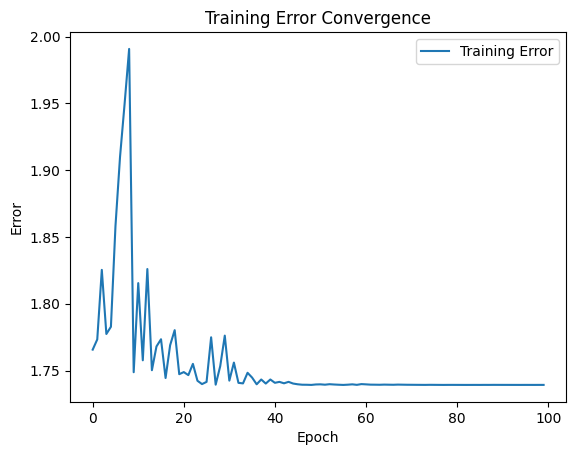

array([ 1.44470251, -0.24890532])

In [17]:
train_svm_linear_errorplot(X_tiny,y_tiny, 10,10, 100, 0.1)

### **`toydata_large`**

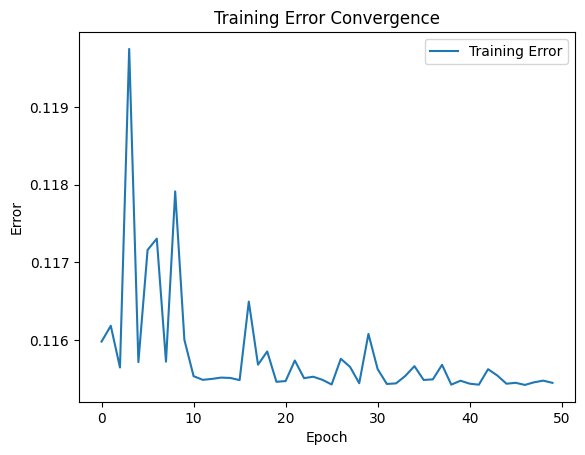

array([0.1309691 , 0.15127775, 0.16303025, 0.08737194, 0.15341395,
       0.16651231, 0.12557998, 0.15740907])

In [18]:
train_svm_linear_errorplot(X_large,y_large, 10, 0.5, 50, 0.1)

**`imdb`:**

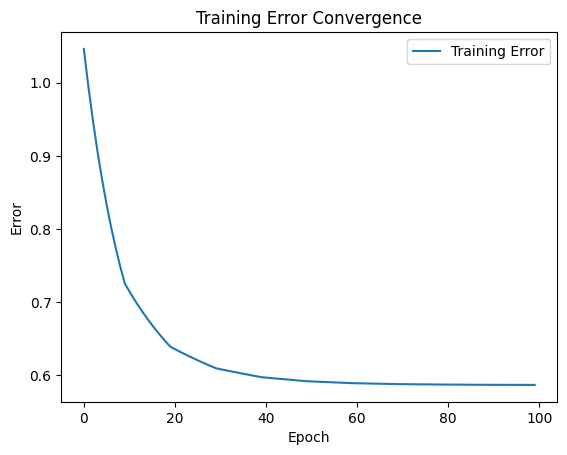

array([0.2179712 , 0.33800914])

In [19]:
train_svm_linear_errorplot(X_imdb,y_imdb, 20, 1, 100, 0.001)

### Briefly discuss your implementation of the SVM and SGD.
svm_loss function:

Calculates the SVM loss, which is the sum of the hinge loss and the L2 regularization loss.
The hinge loss is computed as: C * np.mean(np.maximum(0, 1 - y * np.dot(X, W))), where C is the regularization strength, y is the target vector, X is the feature matrix, and W is the weight vector.
The regularization loss is 0.5 * np.dot(W, W).


svm_gradient function:

Calculates the gradient of the SVM loss with respect to the weight vector W.
Iterates over the batch and computes the gradient contribution for each misclassified point: C * (-y_i * x_i), where y_i is the target value and x_i is the feature vector for the i-th data point.
Averages the gradient over the batch size.
Adds the gradient of the regularization term (W) to the gradient.


train_svm_linear function:

Initializes the weight vector w with random values.
Shuffles the data and divides it into batches.
For each batch:

Calculates the gradient using svm_gradient.
Updates the weight vector w using SGD: w -= lr * grad, where lr is the learning rate.


Optionally decreases the learning rate gradually.
Returns the final weight vector w after all epochs.



Our implementation utilizes SGD to optimize the SVM loss function, which combines the hinge loss for misclassified data points and L2 regularization to prevent overfitting. The gradient of the loss is calculated for each batch, and the weights are updated using SGD, iterating over multiple epochs to convergence.

## Adagrad

### What is the impact of the adagrad regarding the performance in comparison to standard SGD for the different datasets?

- **`toydata_large` dataset:**
  - **SGD (Linear model):** Best Accuracy = 1.0
  - **Adagrad (Linear model):** Best Accuracy = 1.0
  - *Observation:* Both methods performed identically in terms of accuracy. 

- **`toydata_tiny` dataset:**
  - **SGD (Linear model):** Best Accuracy = 0.995
  - **Adagrad (Linear model):** Best Accuracy = 0.995
  - *Observation:* As with the `toydata_large` dataset, no difference in final accuracy was noted. 

- **`imdb` dataset:**
  - **SGD (Linear model):** Best Accuracy = 0.763
  - **Adagrad (Linear model):** Best Accuracy = 0.765
  - *Observation:* The Adagrad optimizer showed a slight improvement over standard SGD. This suggests that Adagrad's adaptive learning rates were beneficial for handling the more diverse and complex features.

#### Summary

Impact of Adagrad compared to standard SGD varies based on the complexity and characteristics of the dataset:
- When the feature scales are relatively uniform and the data is less sparse (`toydata` series), the advantage of Adagrad in terms of performance might not be significant.
- Also the first dataset is really easy for a svm and therefore all implementations perform really well and there is not too much difference to be seen here 
- For datasets like `imdb`, which likely contain more sparse and irregular data (common in text data), Adagrad can outperform standard SGD by adapting the learning rates to the nature of each feature, leading to more efficient learning dynamics.

### Repeat your experiments using random dropout of input features with probabilityp = 0.5 for the IMDB data. Does this change affect performance and if so, how? 

So first I thought about what should happen. As the random dropout decreases the amount of features the algorithm can learn from it should decrease the performance (accuracy) of the algorithm. I mean it is probably faster but the accuracy should decrease. 

Results with droput:
{'imdb': {'adagrad': {'Best Parameters': {'C': 0.5, 'epochs': 20, 'lr': 0.001, 'batch_size': 20}, 'Best Accuracy': 0.724}}}
Runtime 6 seconds

Results without dropout:
{'imdb': {'adagrad': {'Best Parameters': {'C': 0.5, 'epochs': 20, 'lr': 0.001, 'batch_size': 20}, 'Best Accuracy': 0.74}}}
Runtime 7 seconds

So the accuracy decreased by 0.016 but the runtime decreased by 1 second. So the algorithm is faster but less accurate. Like predicted.
However I am pretty suprised that the accuracy is still pretty high. I would have expected a bigger decrease in accuracy, as many 


### Briefly discuss your implementation of Adagrad. How did you adjust it to perform stochastic optimization instead of online learning. Provide pseudo-code.
The code is adapted in order to handle the mini batches instead of the online learning. 
At the beginning the vector w is inialized to zero and the gradient accumulate is also set to zero. 
Then the number of batches is calculated and the data is shuffled.

For each batch the gradient is calculated and the gradient accumulate is updated. The learning rate is adjusted by dividing the learning rate by the square root of the gradient accumulate. The weights are updated by subtracting the adjusted learning rate times the gradient.

the gradient gets updated in each iteration by updating the gradient the adjusted learning rate is calculated 
Each parameter has its own learning rate which is adjusted by the gradient accumulate. This is for the correct implementation of the adagrad algorithm.

peseudo code implementation (however in my opinion just looking at the code is more usefull)
'''
Initialize weights vector 'w' as zero
Initialize 'gradient_accumulate' as zero
Set 'epsilon' to a small constant (e.g., 1e-8) to avoid division by zero

For each epoch from 1 to total_epochs:
    For each batch from 1 to total_number_of_batches:
        Extract batch 'X_batch' and 'y_batch' from 'X' and 'y'
        
        Calculate the gradient 'grad' of the loss function with respect to 'w' using 'X_batch' and 'y_batch'
        Square 'grad' and add to 'gradient_accumulate'
        
        Adjust learning rate for each weight:
            'adjusted_lr' = initial_learning_rate / (sqrt('gradient_accumulate') + 'epsilon')
        
        Update weights 'w':
            'w' = 'w' - 'adjusted_lr' * 'grad'

Return 'w'

'''

## RFF

### Include a plot illustrating convergence of SGD/Adagrad for your selected hyper paramters (this can be for a single fold, and should show the training error over the number of SGD/Adagrad epochs).

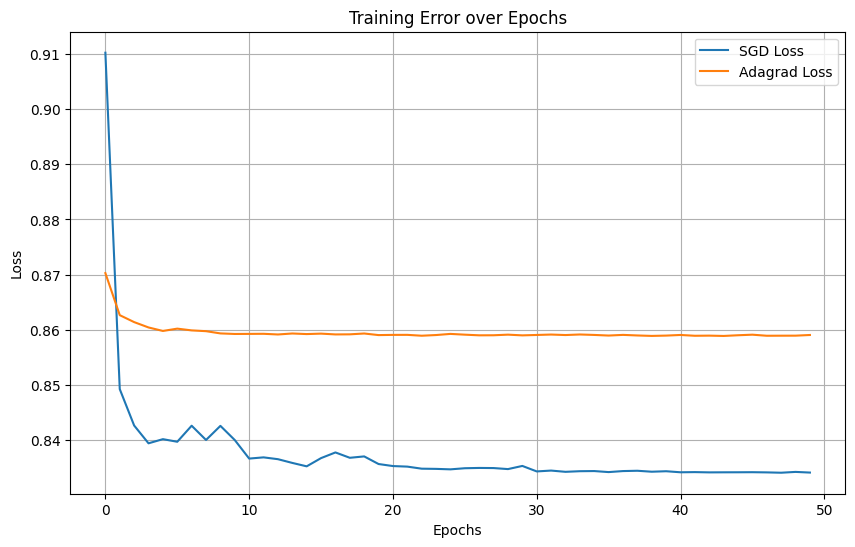

In [20]:
# Training the models
_, _, _, sgd_losses = train_svm_rff_hist(X_imdb, y_imdb, batch_size=10, gamma=0.01, n_features=500, C=1.0, epochs=50, lr=0.01)
_, _, _, adagrad_losses = train_svm_adagrad_rff_hist(X_imdb, y_imdb, batch_size=10, gamma=0.01, n_features=500, C=1.0, epochs=50, lr=0.01)

# Plotting the losses
plot_loss(sgd_losses, adagrad_losses, epochs=50)



### Does the number of RFFs affect the classification accuracy? If so, how?
The number of RFFs directly affects the model's ability to capture complex patterns in the data:

- **Dimensionality vs. Complexity:** Increasing the number of RFFs enhances the model's capacity to represent more complex functions. A higher dimensionality can improve the accuracy of the approximation to the desired kernel function, potentially leading to better classification performance.

- **Overfitting vs. Underfitting:** With too few Fourier features, the model may underfit, failing to capture essential data characteristics. Conversely, too many features might lead to overfitting, particularly in scenarios with limited training data, where the model learns noise in the training set rather than generalizing from true underlying patterns.

- **Computational Efficiency:** A larger number of features increases computational cost, both in terms of memory and processing time. This factor must be balanced against the potential gains in model accuracy and generalization.

- **Toydata Tiny and Large datasets:** A moderate number of RFFs (e.g., 500-1000) already achieved the maximum accuracy. This indicates that beyond a certain threshold, additional features do not necessarily improve performance, likely due to the simpler nature of the datasets.

- **IMDb dataset:** A significant improvement in accuracy was observed when increasing the number of RFFs from 1000 to 2000. This improvement suggests that for more complex datasets with intricate patterns, a higher number of features can better capture the complexity and nuances of the data.

### Briefly discuss your implementation of RFFs.
$\omega$ is sampled from the Gaussian distribution $N(0, 2\pi \gamma)$ and $b$ is sampled uniformly from $[0, 2\pi]$.  

```python
omega = np.random.normal(scale=2*np.pi*gamma, size=(X.shape[1], n_features))
b = np.random.uniform(0, 2*np.pi, size=n_features)
```
   
Then the input data X is transformed using the approximate feature map $\phi(x) = \cos(X \cdot \omega + b)$.   

```python
X_transformed = rff_gaussian_transform(X, omega, b)
def rff_gaussian_transform(X, omega, b):
X_features = np.dot(X, omega) + b
return np.cos(X_features)
```
   
This transformed feature set is an approximation of the high-dimensional space of the Gaussian kernel.
Now we can use the transformed features in the SVM, as if it were using the original kernel.   
 
```python
w = train_svm_linear(X_transformed, y, batch_size, C=C, epochs=epochs, lr=lr)
```

The other versio nof our RFF implementation useses the adagrad svm instead of this regular svm. The results between the two can be found in the graph above.
The code for the adagrad version just changes one line basically

```python
w = train_svm_adagrad(X_transformed, y, batch_size, C=C, epochs=epochs, lr=lr)
```


### For IMDB, report the runtime and performance (in plots or a single plot) when training on 1000, 2000, and 3000 training samples, respectively. Report the same when using sklearn’s svm.SVC class. What do you observe?

In [28]:
# Timing and training with Random Fourier Features and linear SVM
start_time = time.time()
train_svm_rff(X_imdb, y_imdb, 10, 0.1, 2000,10, 10, 0.001)
end_time = time.time()
print(f"Time taken for Random Fourier Features with linear SVM method: {end_time - start_time} seconds")

Time taken for Random Fourier Features with linear SVM method: 0.22517108917236328 seconds


In [25]:
sample_sizes = [1000, 2000, 3000]
from sklearn.svm import SVC
import matplotlib.pyplot as plt

results = []

for size in sample_sizes:
    X_subset = X_imdb[:size]
    y_subset = y_imdb[:size]
    
    # Custom SVM with RFF
    custom_time_start = time.time()
    w, omega, b = train_svm_rff(X_subset, y_subset, batch_size=10, gamma=0.1, n_features=2000, C=10, epochs=50, lr=0.001)
    predictions = predict_rff(X_subset, w, omega, b)
    custom_accuracy = accuracy(y_subset, predictions)  
    print(custom_accuracy)
    custom_time = time.time() - custom_time_start

    # sklearn SVM
    clf = SVC(kernel='rbf', gamma='scale')
    start_time = time.time()
    clf.fit(X_subset, y_subset)
    sklearn_time = time.time() - start_time
    sklearn_accuracy = clf.score(X_subset, y_subset)

    results.append((custom_time, custom_accuracy, sklearn_time, sklearn_accuracy))


0.494
0.494
0.494


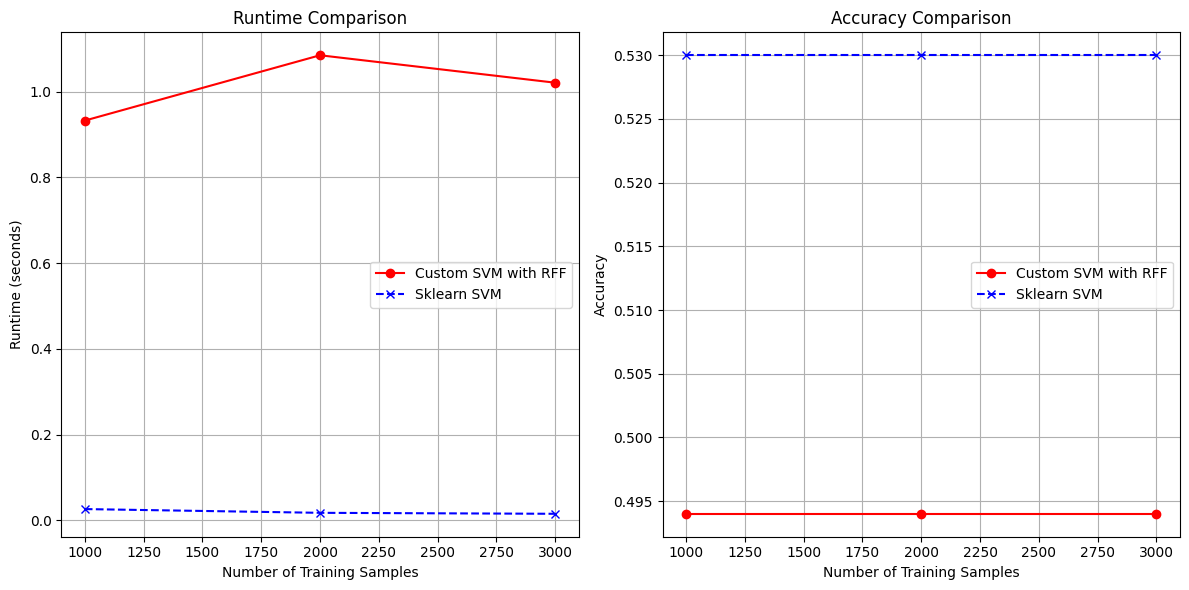

In [26]:
# Extract information
custom_times, custom_accuracies, sklearn_times, sklearn_accuracies = zip(*results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Runtime comparison
ax1.plot(sample_sizes, custom_times, 'o-', color='red', label='Custom SVM with RFF')
ax1.plot(sample_sizes, sklearn_times, 'x--', color='blue', label='Sklearn SVM')
ax1.set_title('Runtime Comparison')
ax1.set_xlabel('Number of Training Samples')
ax1.set_ylabel('Runtime (seconds)')
ax1.legend()
ax1.grid(True)  # Adding grid for better readability


# Accuracy comparison
ax2.plot(sample_sizes, custom_accuracies, 'o-', color='red', label='Custom SVM with RFF')
ax2.plot(sample_sizes, sklearn_accuracies, 'x--', color='blue', label='Sklearn SVM')
ax2.set_title('Accuracy Comparison')
ax2.set_xlabel('Number of Training Samples')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)  # Adding grid for better readability

# Ensuring all plots are properly spaced
plt.tight_layout()
plt.show()

Here we see that it is very interesting that the runtime for our implementation is not always getting lower with more training samples (However if you rerun the code for the graph times this can change I tried it multiple times and the results really vary a lot sometimes, both for the sklearn svm as well as our implementation). But this can be the case if the functions converges faster because there are more infos to be used. Also mabye overfitting is reduced this way and the result better. However the results stay pretty much the same between all the different number of training samples as can be seen in the right plot.